In [2]:
import pandas as pd

In [3]:
df_hsk = pd.concat(
    (
        pd.read_csv(f"data/hsk{i}.csv", names=["simplified", "pinyin", "meanings"])
        .assign(level=i)
    )
    for i in range(1,7)
)[["simplified", "pinyin", "meanings", "level"]]

In [4]:
def vowelsToTone(pinyin):
    accentMap = {
        "a": ["ā", "á", "ǎ", "à"],  #, "a"],
        "A": ["Ā", "Á", "Ǎ", "À"],  #, "A"],
        "e": ["ē", "é", "ě", "è"],  #, "e"],
        "E": ["Ē", "É", "Ě", "È"],  #, "E"],
        "i": ["ī", "í", "ǐ", "ì"],  #, "i"],
        "I": ["Ī", "Í", "Ǐ", "Ì"],  #, "I"],
        "o": ["ō", "ó", "ǒ", "ò"],  #, "o"],
        "O": ["Ō", "Ó", "Ǒ", "Ò"],  #, "o"],
        "u": ["ū", "ú", "ǔ", "ù"],  #, "u"],
        "U": ["Ū", "Ú", "Ǔ", "Ù"],  #, "u"],
        "v": ["ǖ", "ǘ", "ǚ", "ǜ"],  #, "ü"],
        "V": ["Ǖ", "Ǘ", "Ǚ", "Ǜ"],  #, "Ü"],
    }
    def vowelToTone(word):
        for noAccent, accents in accentMap.items():
            for i, accent in enumerate(accents):
                if accent in word:
                    return f"{word.replace(accent, noAccent)}{i+1}"
        return f"{word}5"
        
    return " ".join(vowelToTone(x) for x in pinyin.split(" "))

df_hsk = df_hsk.assign(pinyin=df_hsk["pinyin"].map(vowelsToTone))
df_hsk

,simplified,pinyin,meanings,level
0,爱,ai4,to love,1
1,八,ba1,eight,1
2,爸爸,ba4 ba5,(informal) father,1
3,杯子,bei1 zi5,cup,1
4,北京,Bei3 jing1,Beijing,1
...,...,...,...,...
2495,座右铭,zuo4 you4 ming2,motto,6
2496,作弊,zuo4 bi4,to practice fraud,6
2497,作废,zuo4 fei4,to become invalid,6
2498,作风,zuo4 feng1,style,6


In [5]:
df_hsk["level"].value_counts()

6    2500
5    1300
4     601
3     299
1     150
2     150
Name: level, dtype: int64

In [18]:
hsk_levels = {1,2,3}
# df_hsk["simplified"].str.split("")
words = df_hsk[df_hsk["level"].isin(hsk_levels)]["simplified"]
zi_set = set(''.join(words))
len(zi_set)

618

In [19]:
import networkx as nx
import math
import numpy as np
import numpy.linalg as lalg
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, to_tree


def construct_undirected_graph(words: pd.Series):
    G = nx.Graph()
        
    for _, word in words.items():
        for i in range(len(word) - 1):
            source, target = word[i:i+2]
            # TODO handle same adjacency for different ci
            G.add_edge(source, target, duality="adjacency", ci=word)
            
    return G

def embed_snapshot_markov(G, steps, degrees=False):
    '''embedding of pons & lapaty, including extra weighting using degrees'''
    # get markov matrix P
    n = len(G)
    A = nx.to_numpy_array(G)
    D = np.identity(n) * np.sum(A, axis=1)
    P = lalg.inv(D) @ A
    
    # steps
    P = lalg.matrix_power(P, steps)
    if degrees:
        P = lalg.inv(sqrtm(D)) @ P
    return P

def cluster_walktrap(embedding, method='ward', opt_ord=False):
    dist = pdist(embedding, metric='euclidean')
    # print(is_metric(dist))
    return linkage(dist, method=method, optimal_ordering=opt_ord)


In [20]:
G = construct_undirected_graph(words)
embedding = embed_snapshot_markov(G, 5)
Z = cluster_walktrap(embedding, 'ward', True)

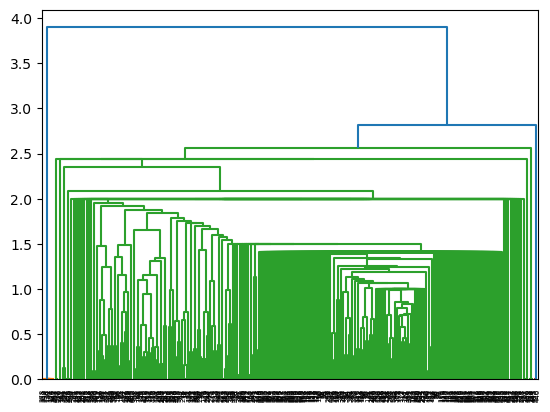

In [21]:
from scipy.cluster.hierarchy import dendrogram
_ = dendrogram(Z)

In [54]:
from scipy.cluster.hierarchy import to_tree, ClusterNode

class TreeNode:
    '''needed because ClusterNode for dendrogram is binary'''
    def __init__(self, id_, dist):
        self.id = id_
        self.dist = dist
        self.children = []
        
        self.parent = None
        self.length = None
        self.angle = None
        
def prune(G: nx.Graph, clustroot: ClusterNode, merge_threshold: float, length_exp=1) -> TreeNode:
    id_map = {i:x for i, x in enumerate(G.nodes())}
    
    # first build tree with merged branches
    def build(node: ClusterNode):
        if node is None:
            return None
        
        here = TreeNode(id_map.get(node.id, node.id), node.dist/clustroot.dist) # normalise
        left = build(node.left)
        right = build(node.right)
        
        # if leaf, just return
        if left is None:
            assert right is None # should be satisfied from dendrogram
            return here
    
        # merge child into self if not leaf and gap is smaller than min
        if len(left.children) != 0 and here.dist-left.dist < merge_threshold:
            here.children.extend(left.children)
        else:
            here.children.append(left)
        # and same for right
        if len(right.children) != 0 and here.dist-right.dist < merge_threshold:
            here.children.extend(right.children)
        else:
            here.children.append(right)
        return here
    
    root = build(clustroot)

    # count number of leaves and set parent pointers
    nleaves = 0
    nbranches = 0
    def count(node: TreeNode):
        if node is None:
            return
        if len(node.children) == 0:
            nonlocal nleaves
            nleaves += 1
        else:
            nonlocal nbranches
            nbranches += 1
            for child in node.children:
                child.parent = node
                count(child)
                
    count(root)
    
    # place each node at the midangle of its children
    n = nleaves + nbranches
    leafcounter = 0
#     branchcounter = 0
    def place(node: TreeNode):
        assert node is not None
        if len(node.children) == 0:
            nonlocal leafcounter
            node.angle = (leafcounter / nleaves) * 2 * math.pi
            node.length = 1
            leafcounter += 1
            return 1
        else:
            total_leaves = sum(place(child) for child in node.children)
            node.length = (1 - (total_leaves / nleaves)) ** length_exp # exponent makes layout more uniform
#             node.angle = (node.children[0].angle + node.children[-1].angle) / 2
            node.angle = sum(c.angle for c in node.children) / len(node.children)
            
#             # reassign indices to make contiguous
#             nonlocal branchcounter
#             node.idx = nleaves + branchcounter
#             branchcounter += 1
            return total_leaves
        
    place(root)
    return root

In [109]:
root = prune(G, to_tree(Z), 0.01, 10)

In [110]:
def construct_dual_graph(root: TreeNode, words: pd.Series):
    trie = nx.DiGraph()
    
    def add_hierarchy(node: TreeNode):
        for child in node.children:
            trie.add_edge(node.id, child.id, duality="hierarchy")
            trie.nodes[child.id]["parent"] = node.id
            add_hierarchy(child)
        
        trie.nodes[node.id]["position"] = np.array([
            node.length * math.cos(node.angle),
            node.length * math.sin(node.angle),
        ])
        if not node.children:
            trie.nodes[node.id]["leaf"] = True
    
    add_hierarchy(root)
    trie.graph["root"] = root.id
    
    # checks if it is a tree
    assert nx.is_arborescence(trie)
    
    # add reference to parent for easier LCA calc
    for source, target in list(trie.edges):
        trie.nodes[target]["parent"] = source
        
    for _, word in words.items():
        for i in range(len(word) - 1):
            source, target = word[i:i+2]
            trie.add_edge(source, target, duality="adjacency")
            
    return trie

In [111]:
trie = construct_dual_graph(root, words)

In [112]:
import matplotlib.pyplot as plt

(-1.1, 1.1, -1.0999736640495639, 1.0999736640495639)

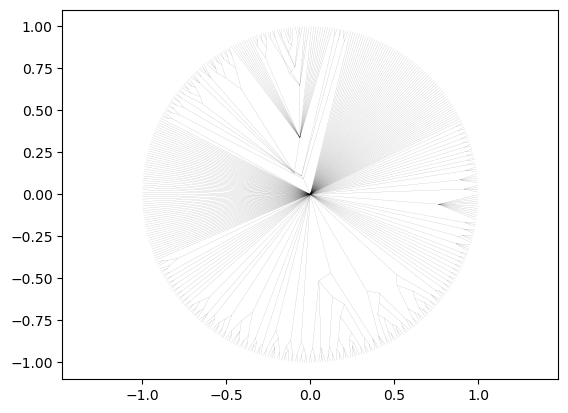

In [113]:
fig, ax = plt.subplots()

for source, target, data in trie.edges(data=True):
    if data["duality"] != "hierarchy":
        continue
    x0, y0 = trie.nodes[source]["position"]
    x1, y1 = trie.nodes[target]["position"]
    ax.plot([x0,x1], [-y0,-y1], color='k', linewidth=0.05)

ax.axis('equal')

In [114]:
def route_via_lca(trie: nx.DiGraph, source, target, skip_lca=True):
    source_to_lca = [source]
    target_to_lca = []

    source_to_root = {trie.graph["root"]}
    while source != trie.graph["root"]:
        source_to_root.add(source)
        source = trie.nodes[source]["parent"]
    
    while target not in source_to_root:
        target_to_lca.append(target)
        target = trie.nodes[target]["parent"]
    
    lca = target
    
    while source_to_lca[-1] != lca:
        source_to_lca.append(trie.nodes[source_to_lca[-1]]["parent"])
    
    if skip_lca and len(source_to_lca) + len(target_to_lca) > 3:
        source_to_lca = source_to_lca[:-1]
    
    source_to_lca.extend(reversed(target_to_lca))
    return source_to_lca

def bundle_adjacency(trie: nx.DiGraph, skip_lca=True):
    for source, target in [(s,t) for s,t,d in trie.edges(data=True) if d["duality"] == "adjacency"]:
        knots = route_via_lca(trie, source, target, skip_lca)
        trie.edges[source, target]["knots"] = knots
        

In [115]:
bundle_adjacency(trie)

In [116]:
    def draw_bspline_cubic(path: list[tuple]) -> str:
    """draws a cubic b-spline, with an open knot vector and repeated control points"""
    svg = []
    m = len(path)
    if m < 2:
        raise ValueError("path is less than 2 points long")
    elif m == 2:
        p0 = path[0]
        p1 = path[1]
        svg.append(f'<path d="M {p0[0]:.1f} {p0[1]:.1f} L {p1[0]:.1f} {p1[1]:.1f}"/>')
    else:
        p000 = path[0] # not strictly correct, but works
        p112 = 2/3*path[0] + 1/3*path[1]
        p122 = 1/3*path[0] + 2/3*path[1]
        svg.append(f'<path d="M {p000[0]:.1f} {p000[1]:.1f} C {p112[0]:.1f} {p112[1]:.1f} {p122[0]:.1f} {p122[1]:.1f}')

        for i in range(1, len(path)-1):
            p123 = path[i]
            p234 = path[i+1]
            p223 = 2/3*p123 + 1/3*p234
            p233 = 1/3*p123 + 2/3*p234
            p222 = .5*p122 + .5*p223

            svg.append(f' {p222[0]:.1f} {p222[1]:.1f} S {p233[0]:.1f} {p233[1]:.1f}')
            p122 = p233

        end = path[-1]
        svg.append(f' {end[0]:.1f} {end[1]:.1f}"/>')

    return(''.join(svg))

def draw_svg(
    trie: nx.DiGraph,
    beta=.75,
    width=750,
    border=50,
    linkwidth=.05,
    noderadius=.1,
    linkopacity=1,
    nodeopacity=1,
    fontsize=3,
) -> str:
    scale = width-2*border
    svg = []
    svg.append(f'<svg width="{width:.0f}" height="{width:.0f}" xmlns="http://www.w3.org/2000/svg">')
    svg.append('<style type="text/css">')
    svg.append(f'path{{stroke:black;stroke-width:{scale*linkwidth:.3f};stroke-opacity:{linkopacity:.3f};stroke-linecap:round;fill:transparent}}')
    svg.append(f'circle{{r:{scale*noderadius:.3f};stroke-width:0;fill-opacity:{nodeopacity:.3f}}}')
    svg.append('</style>')
    
    # add white background
    svg.append('<rect width="100%" height="100%" fill="white"/>')
    
    
    x_min, y_min = 2 * [float("inf")]
    x_max, y_max = 2 * [-float("inf")]
    for node, data in trie.nodes(data=True):
        x_min = min(x_min, data["position"][0])
        y_min = min(y_min, data["position"][1])
        x_max = max(x_max, data["position"][0])
        y_max = max(y_max, data["position"][1])
    
    # want to scale everything to 0-1 first
    unit_scale = 1 / max(x_max - x_min, y_max - y_min)
    unit_trans = -np.array([x_min, y_min])
    
    # move to (0,0)-(1,1) then expand to square
    place_node = lambda x: (x + unit_trans) * unit_scale * scale + np.array([border, border])
    
    # draw splines
    for source, target, data in trie.edges(data=True):
        if data["duality"] != "adjacency" or source == target:
            continue
            
        spline = place_node(np.array([trie.nodes[knot]["position"] for knot in data["knots"]]))
        
        # straighten with beta as per (Holten, 2006)
        for i in range(1, len(spline)-1):
            spline[i] = beta*spline[i] + (1-beta) * (spline[0] + (i/(len(spline)-1))*(spline[-1]-spline[0]))
            
        svg.append(draw_bspline_cubic(spline))
        
    for node, data in trie.nodes(data=True):
        if data.get("leaf", False):
            zi_position = place_node(data["position"])
            svg.append(f'<text x="{zi_position[0]}" y="{zi_position[1]}" text-anchor="middle" text-align="center" font-size="{fontsize}">{node}</text>')

    svg.append('</svg>')

    return '\n'.join(svg)

In [117]:
from cairosvg import svg2png

svg = draw_svg(trie, beta=0.75, linkwidth=0.003, linkopacity=0.2, noderadius=0.012)
with open(f'bundled.svg', 'w') as f:
    print(svg, file=f)
svg2png(bytestring=svg, write_to=f'bundled.png', dpi=400)